In [33]:
import numpy as np
import matplotlib.pyplot as plt

## Victor Purpura 

VP cost D = 2.800 (q=0.4) | moves=5, deletes=2, inserts=0


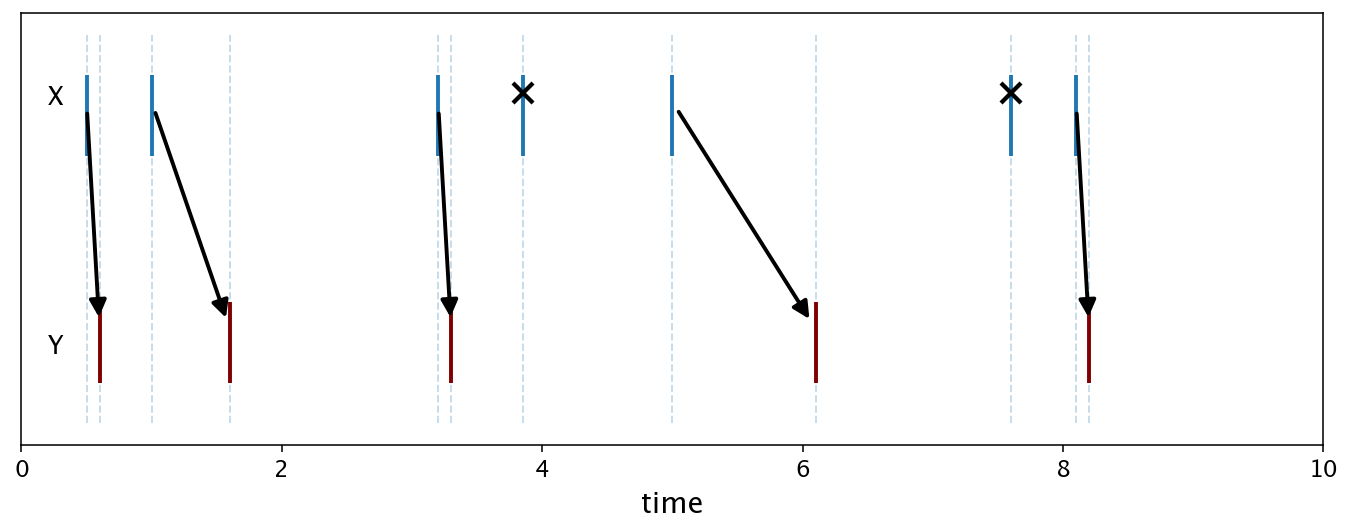

In [34]:
# przykładowe spiki, tylko do wizualizacji idei metryk 
X = np.array([0.50, 1.00, 3.20, 3.85, 5.00, 7.60, 8.10]) 
Y = np.array([0.60, 1.60, 3.30, 6.10, 8.20])              

q = 0.4   # koszt przesunięcia

def victor_purpura(X, Y, q):
    X = np.asarray(X, float); Y = np.asarray(Y, float)
    n, m = len(X), len(Y)
    D = np.zeros((n+1, m+1), float)
    bp = np.empty((n+1, m+1), dtype=object)

    for i in range(1, n+1):
        D[i, 0] = i; bp[i, 0] = ('del', i-1, None)
    for j in range(1, m+1):
        D[0, j] = j; bp[0, j] = ('ins', None, j-1)

    for i in range(1, n+1):
        for j in range(1, m+1):
            c_del = D[i-1, j] + 1.0
            c_ins = D[i, j-1] + 1.0
            c_mov = D[i-1, j-1] + q * abs(X[i-1] - Y[j-1])
            c_min = min(c_del, c_ins, c_mov)
            D[i, j] = c_min
            if abs(c_min - c_mov) < 1e-12:
                bp[i, j] = ('mov', i-1, j-1)
            elif abs(c_min - c_del) < 1e-12:
                bp[i, j] = ('del', i-1, None)
            else:
                bp[i, j] = ('ins', None, j-1)
    ops = []
    i, j = n, m
    while i > 0 or j > 0:
        op, ii, jj = bp[i, j]
        if op == 'mov':
            ops.append({'type': 'move', 'xi': X[ii], 'yi': Y[jj], 'cost': q*abs(X[ii]-Y[jj])})
            i -= 1; j -= 1
        elif op == 'del':
            ops.append({'type': 'delete', 'xi': X[ii], 'yi': None, 'cost': 1.0})
            i -= 1
        else:
            ops.append({'type': 'insert', 'xi': None, 'yi': Y[jj], 'cost': 1.0})
            j -= 1
    ops.reverse()
    return D[n, m], ops

D, ops = victor_purpura(X, Y, q)

# podsumowanie
nm = sum(o['type']=='move' for o in ops)
nd = sum(o['type']=='delete' for o in ops)
ni = sum(o['type']=='insert' for o in ops)
print(f"VP cost D = {D:.3f} (q={q}) | moves={nm}, deletes={nd}, inserts={ni}")

T0, T1 = 0.0, 10.0
fig, ax = plt.subplots(figsize=(12, 4), dpi=140)

# raster
ax.vlines(X, 0.82, 1.18, linewidth=2, zorder=1)
ax.vlines(Y, -0.18, 0.18, linewidth=2, zorder=1, color="maroon")

# pionowe przerywane w miejscach spików
for s in sorted(np.unique(np.concatenate([X, Y]))):
    ax.axvline(s, ymin=0.05, ymax=0.95, ls='--', lw=1, alpha=0.25, zorder=0)

ax.text(T0 + 0.02*(T1-T0), 1.05, "X", fontsize=13)
ax.text(T0 + 0.02*(T1-T0), -0.05, "Y", fontsize=13)

# strzałki 
for step in ops:
    if step['type'] == 'move':
        xi, yj = step['xi'], step['yi']
        ax.annotate(
            "", xy=(yj, 0.06), xytext=(xi, 1.06),
            arrowprops=dict(arrowstyle="-|>", lw=2, mutation_scale=18,
                            color="black", shrinkA=6, shrinkB=6),
            zorder=5, clip_on=False
        )
    elif step['type'] == 'delete':
        ax.plot([step['xi']], [1.10], marker='x', ms=10, mew=2.2, color="black", zorder=4)
    else: 
        ax.plot([step['yi']], [-0.10], marker='+', ms=12, mew=2.2, color="black", zorder=4)

ax.set_xlim(T0, T1)
ax.set_ylim(-0.45, 1.45)
ax.set_yticks([])
ax.set_xlabel("time", fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=12) 
plt.show()


## Van Rossum

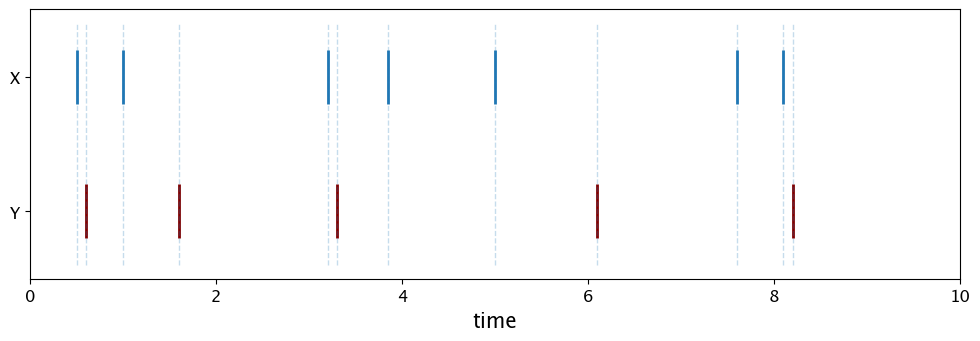

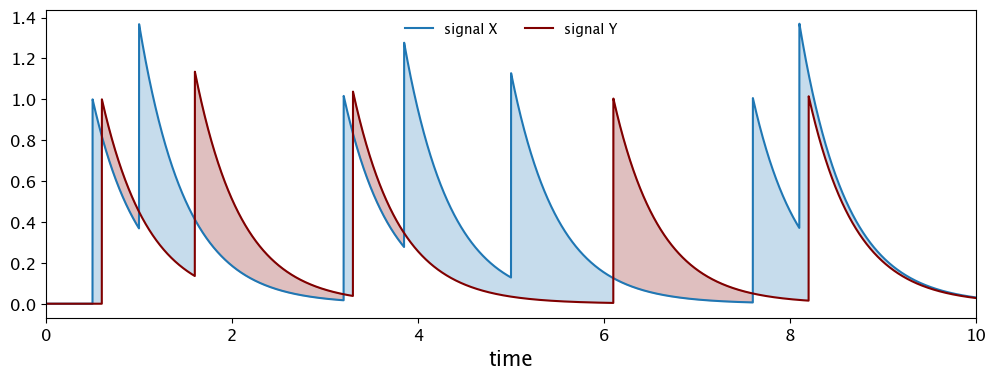

In [35]:
tau = 0.5   #skala czasu 
T0, T1, dt = 0.0, 10.0, 0.001
t = np.arange(T0, T1 + dt, dt)

# ========= 2) van Rossum =========
def filtered_signal(spikes, t, tau):
    f = np.zeros_like(t, float)
    for s in np.asarray(spikes, float):
        m = t >= s
        f[m] += np.exp(-(t[m] - s) / tau)
    return f

def van_rossum_closed_form(x, y, tau):
    x = np.asarray(x, float); y = np.asarray(y, float)
    def exp_sum(a, b):
        if a.size == 0 or b.size == 0: return 0.0
        return np.exp(-np.abs(a[:, None] - b[None, :]) / tau).sum()
    XX = exp_sum(x, x); YY = exp_sum(y, y); XY = exp_sum(x, y)
    d2 = 0.5 * (XX + YY) - XY
    return np.sqrt(max(d2, 0.0)), d2

fX, fY = filtered_signal(X, t, tau), filtered_signal(Y, t, tau)
d2_num = (1.0 / tau) * np.trapz((fX - fY) ** 2, t)
d_vr_num = np.sqrt(max(d2_num, 0.0))
d_vr_cf, d2_vr_cf = van_rossum_closed_form(X, Y, tau)

#przykład
fig1, ax1 = plt.subplots(figsize=(12, 3.5))
ax1.vlines(X, 0.8, 1.2, linewidth=2)
ax1.vlines(Y, -0.2, 0.2, linewidth=2, color="maroon")
for s in sorted(np.unique(np.concatenate([X, Y]))):
    ax1.axvline(s, ymin=0.05, ymax=0.95, ls='--', lw=1, alpha=0.25)
ax1.set_ylim(-0.5, 1.5); ax1.set_xlim(T0, T1)
ax1.set_yticks([0, 1]); ax1.set_yticklabels(["Y", "X"])
ax1.set_xlabel("time", fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=12) 


# van Rossum
fig2, ax2 = plt.subplots(figsize=(12, 4))
ax2.plot(t, fX, label="signal X")
ax2.plot(t, fY, label="signal Y", color="maroon")
ax2.fill_between(t, fX, fY, where=(fX >= fY), alpha=0.25, interpolate=True)
ax2.fill_between(t, fY, fX, where=(fY > fX),  alpha=0.25, interpolate=True, color="maroon")
ax2.set_xlim(T0, T1)
ax2.set_xlabel("time", fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=12) 
ax2.legend(ncol=3, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=12) 

plt.show()

# Results

In [1]:
from elephant import *
from neo import SpikeTrain
import pandas as pd
import numpy as np
import quantities as pq
from elephant.spike_train_dissimilarity import van_rossum_distance, victor_purpura_distance
import matplotlib.pyplot as plt

In [6]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [2]:
path_original = "../data/spike_matrix.csv"
path_generated = "../data/spike_generated_LIF.csv"

df_original = pd.read_csv(path_original, header=0)
df_generated = pd.read_csv(path_generated, header=0)
df_generated = df_generated.iloc[:, 1:]


Average Van Rossum Distance for all neurons:
1863.7839986664599
Median distances for all neurons: 1327.8958345464084
std distances for all neurons: 1951.7026945696143


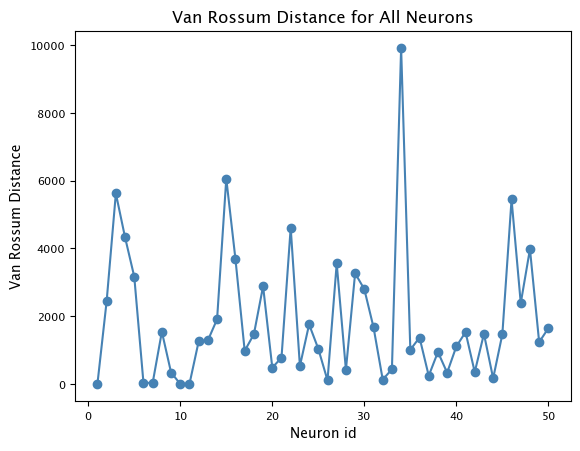

In [7]:
T = 180000  
vr_distances = []
neuron_ids = [] 

for neuron_id in range(1, df_original.shape[1]):  
    # spiki dla danego neuronu
    neuron_original = df_original[df_original.iloc[:, neuron_id] == 1].iloc[:, 0].to_numpy()
    neuron_generated = df_generated[df_generated.iloc[:, neuron_id] == 1].iloc[:, 0].to_numpy()

    # tworzymy SpikeTrainy
    st_a = SpikeTrain(neuron_original * pq.ms, t_stop=T * pq.ms)  
    st_b = SpikeTrain(neuron_generated * pq.ms, t_stop=T * pq.ms)  

    vr_f = van_rossum_distance([st_a, st_b])[0, 1] 
    vr_distances.append(vr_f)
    
    neuron_ids.append(neuron_id)
    #print(f"Neuron {neuron_id} Van Rossum Distance: {vr_f:.8f}")

#statystyki
print("\nAverage Van Rossum Distance for all neurons:")
print(np.mean(vr_distances))
print(f"Median distances for all neurons: {np.median(vr_distances)}")
print(f"std distances for all neurons: {np.std(vr_distances)}")

plt.plot(neuron_ids, vr_distances, marker='o', linestyle='-', color='steelblue')  
plt.title("Van Rossum Distance for All Neurons")
plt.xlabel("Neuron id", fontsize=10)
plt.ylabel("Van Rossum Distance", fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=8)

plt.show()



Average Victor-Purpura Distance for all neurons:
2384.845014000003
Median distances for all neurons: 1706.5056499999987
std  distances for all neurons: 2500.784702838636

Average Van Rossum Distance for all neurons:
1863.7839986664599
Median distances for all neurons: 1327.8958345464084
std distances for all neurons: 1951.7026945696143


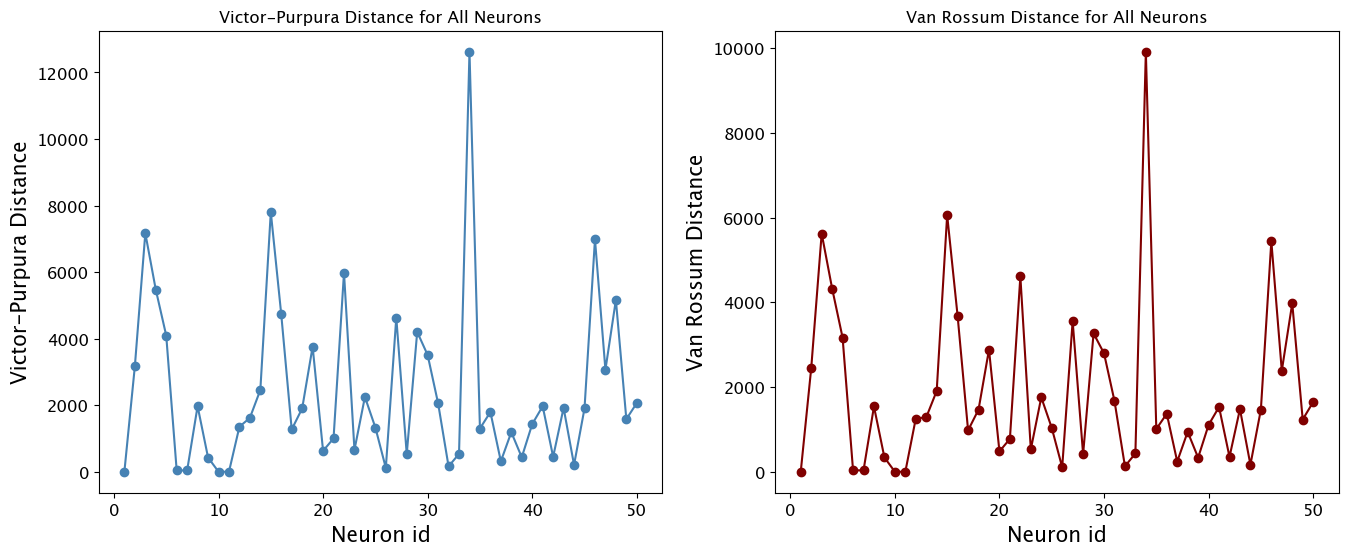

In [14]:
vp_distances = []
vr_distances = []

for neuron_id in range(1, df_original.shape[1]):  
    neuron_original = df_original[df_original.iloc[:, neuron_id] == 1].iloc[:, 0].to_numpy()
    neuron_generated = df_generated[df_generated.iloc[:, neuron_id] == 1].iloc[:, 0].to_numpy()
    st_a = SpikeTrain(neuron_original * pq.ms, t_stop=T * pq.ms)  # original spike train
    st_b = SpikeTrain(neuron_generated * pq.ms, t_stop=T * pq.ms)  # generated spike train

    #Victor-Purpura
    q = 1.0 / (10.0 * pq.ms) 
    vp_f = victor_purpura_distance([st_a, st_b], q)[0, 1] 
    vp_distances.append(vp_f)

    # Van Rossum 
    vr_f = van_rossum_distance([st_a, st_b])[0, 1] 
    vr_distances.append(vr_f)

    #print(f"Neuron {neuron_id} - Victor-Purpura Distance: {vp_f:.8f}")
    #print(f"Neuron {neuron_id} - Van Rossum Distance: {vr_f:.8f}")

#statystyki VP
print("\nAverage Victor-Purpura Distance for all neurons:")
print(np.mean(vp_distances))
print(f"Median distances for all neurons: {np.median(vp_distances)}")
print(f"std  distances for all neurons: {np.std(vp_distances)}")

#statystyki VR
print("\nAverage Van Rossum Distance for all neurons:")
print(np.mean(vr_distances))
print(f"Median distances for all neurons: {np.median(vr_distances)}")
print(f"std distances for all neurons: {np.std(vr_distances)}")

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(vp_distances) + 1), vp_distances, marker='o', linestyle='-', color='steelblue')
plt.title("Victor-Purpura Distance for All Neurons")
plt.xlabel("Neuron id", fontsize=15)
plt.ylabel("Victor-Purpura Distance", fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(vr_distances) + 1), vr_distances, marker='o', linestyle='-', color='maroon')
plt.title("Van Rossum Distance for All Neurons")
plt.xlabel("Neuron id", fontsize=15)
plt.ylabel("Van Rossum Distance", fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()
